In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
from google.colab import drive
import os
import numpy as np # Ensure numpy is imported
from sklearn.preprocessing import LabelEncoder

drive.mount("/content/drive")

def load_and_prepare_data():
    print("Loading data...")
    sequence_dir = '/content/drive/MyDrive/cremad_data_splits/'
    # Load data
    try:
        X = np.load(os.path.join(sequence_dir, 'mfcc_sequences.npy'))
        y_str = np.load(os.path.join(sequence_dir, 'mfcc_sequence_labels.npy'))
    except Exception as e:
        print(f"Error loading data from Google Drive: {e}")
        print(f"Please ensure the path '{sequence_dir}' is correct and Google Drive is mounted properly.")
        raise # Re-raise the exception so the user sees the original traceback

    print(f"Spectrograms shape: {X.shape}")
    print(f"Labels shape: {y_str.shape}")
    print(f"Unique emotions: {np.unique(y_str)}")

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    num_classes = len(label_encoder.classes_)

    print(f"Number of classes: {num_classes}")
    print(f"Class mapping: {dict(zip(label_encoder.classes_, range(num_classes)))}")

    return X, y, num_classes, label_encoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Split data
X, y, num_classes, label_encoder = load_and_prepare_data() # Load data using the updated function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
input_shape = (X_train.shape[1], X_train.shape[2])

Loading data...
Spectrograms shape: (7442, 216, 13)
Labels shape: (7442,)
Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of classes: 6
Class mapping: {np.str_('angry'): 0, np.str_('disgust'): 1, np.str_('fear'): 2, np.str_('happy'): 3, np.str_('neutral'): 4, np.str_('sad'): 5}


In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder, model_display_name, epochs=80, batch_size=32):
    """Trains and evaluates a given model."""
    print(f"\nTraining model: {model_display_name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    # Removed the LRReducerCallback as requested


    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping], verbose=1)

    print("\nEvaluating model...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    # Assuming label_encoder is available in the scope where this function is called
    # If not, you might need to pass it as an argument or retrieve it
    try:
        class_labels = label_encoder.classes_
    except NameError:
        print("Warning: label_encoder not found. Using default labels for confusion matrix.")
        class_labels = [str(i) for i in range(cm.shape[0])]


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


    return history, loss, accuracy

def plot_training_history(history, model_name):
    """Plots training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
def build_rnn_model(input_shape, num_classes):
    """Builds a simple RNN model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape), # Add Input layer here
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Training model: sequential_5
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.1678 - loss: 1.8570 - val_accuracy: 0.1763 - val_loss: 1.8151 - learning_rate: 1.0000e-04
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1758 - loss: 1.8263 - val_accuracy: 0.1906 - val_loss: 1.7992 - learning_rate: 1.0000e-04
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.1889 - loss: 1.8104 - val_accuracy: 0.1872 - val_loss: 1.7981 - learning_rate: 1.0000e-04
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1960 - loss: 1.7963 - val_accuracy: 0.1965 - val_loss: 1.7908 - learning_rate: 1.0000e-04
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.2037 - loss: 1.7872 - val_accuracy: 0.1814 - val_loss: 1.7951 - learning_rate: 1.0000e-04
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2108 - loss: 1.7863 - val_accuracy: 0.1780 - val_loss: 1.7954 - learning_rate: 1.0000e-04
Epoch 7/80
149/149 ━━━━━━━━

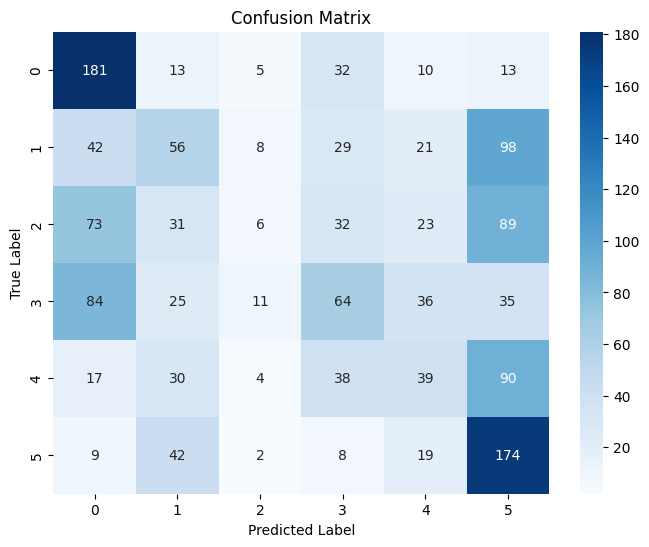

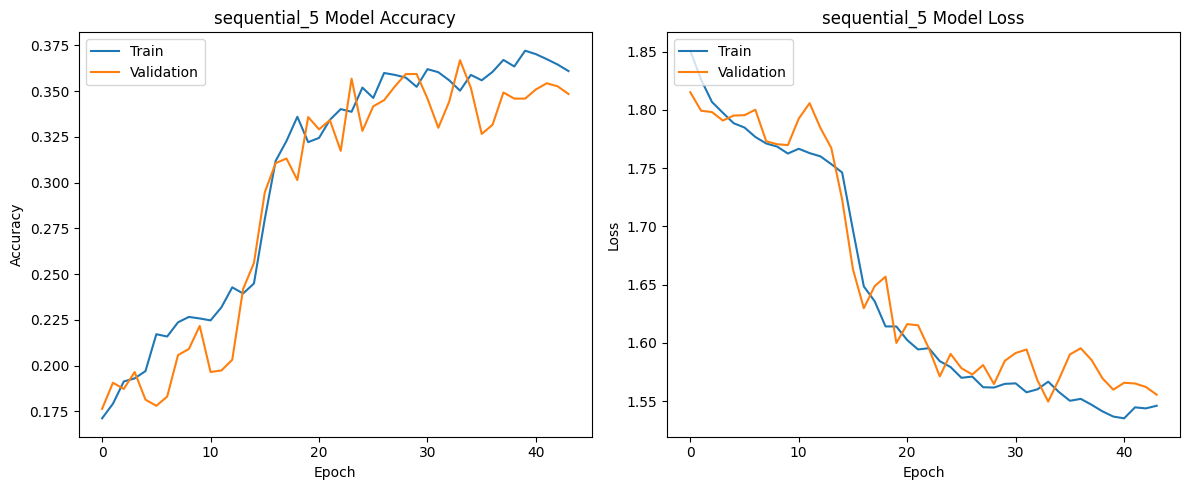

In [ ]:
rnn_model = build_rnn_model(input_shape, num_classes)
rnn_model._name = "Simple_RNN" # Assign a name for plotting

history_rnn, loss_rnn, accuracy_rnn = train_and_evaluate_model(rnn_model, X_train, y_train, X_test, y_test, label_encoder, "Simple_RNN")
plot_training_history(history_rnn, "Simple_RNN")

In [ ]:
def build_rnn_model_highlr(input_shape, num_classes):
    """Builds a simple RNN model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape), # Add Input layer here
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Training model: RNN_HighLR
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.1655 - loss: 1.9374 - val_accuracy: 0.1704 - val_loss: 1.8007
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1727 - loss: 1.9343 - val_accuracy: 0.1704 - val_loss: 1.7913
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1632 - loss: 1.9220 - val_accuracy: 0.1704 - val_loss: 1.8087
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1821 - loss: 1.8927 - val_accuracy: 0.1461 - val_loss: 1.8184
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1605 - loss: 1.8799 - val_accuracy: 0.1772 - val_loss: 1.8044
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1694 - loss: 1.8559 - val_accuracy: 0.1654 - val_loss: 1.8022
Epoch 7/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1657 - loss: 1.8341 - val_accuracy: 0.1587 - val_loss: 1.7981
Epoch 8/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


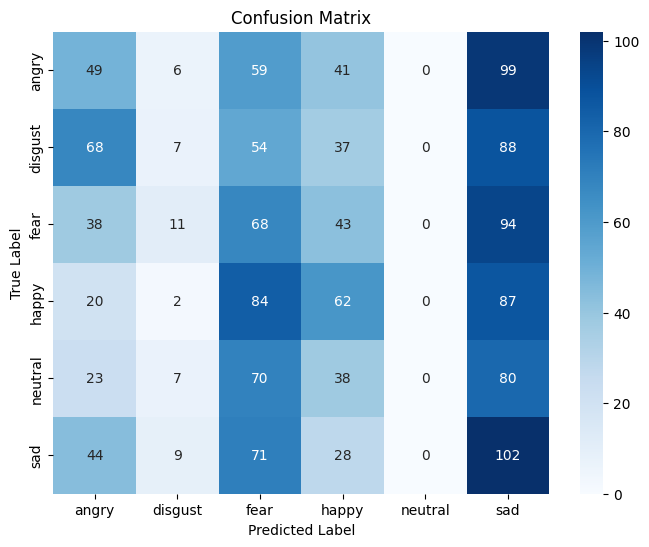

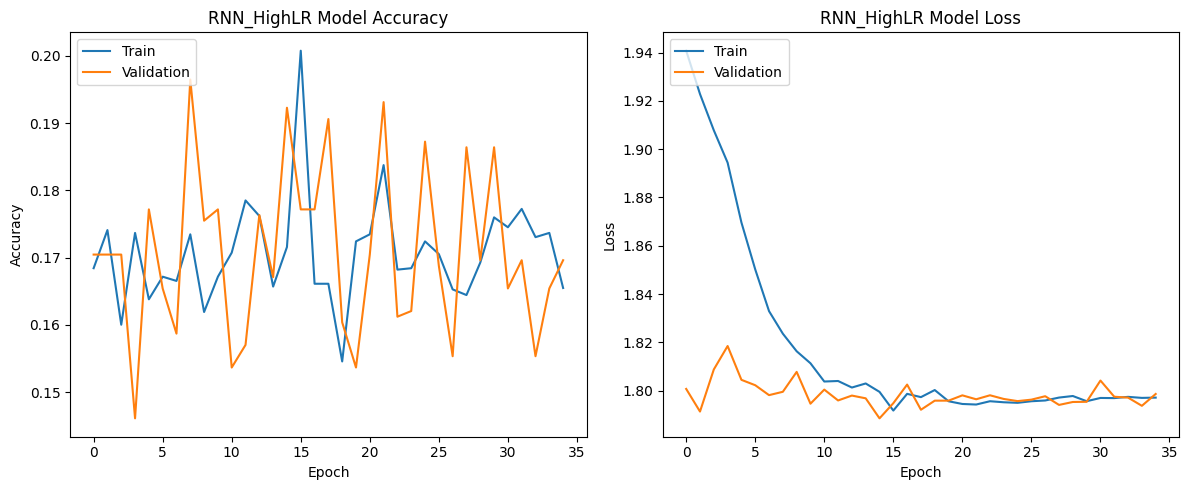

In [ ]:
rnn_highlr = build_rnn_model_highlr(input_shape, num_classes)
rnn_highlr._name = "RNN_HighLR" # Assign a name for plotting

history_rnn_highlr, loss_RNN_HighLR, accuracy_RNN_HighLR = train_and_evaluate_model(rnn_highlr, X_train, y_train, X_test, y_test, label_encoder, "RNN_HighLR")
plot_training_history(history_rnn_highlr, "RNN_HighLR")

# Removing Return Sequences


In [ ]:
def build_rnn_model_noreturn(input_shape, num_classes):
    """Builds a simple RNN model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape), # Add Input layer here
        tf.keras.layers.SimpleRNN(128, return_sequences=False), # Only return the last state
        Dropout(0.3),
        # Removed the second SimpleRNN layer as the output of the first layer is not a sequence
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Training model: RNN_noreturn
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.1681 - loss: 1.7942 - val_accuracy: 0.1755 - val_loss: 1.7902
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2025 - loss: 1.7847 - val_accuracy: 0.2292 - val_loss: 1.7590
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2304 - loss: 1.7653 - val_accuracy: 0.1797 - val_loss: 1.7839
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2514 - loss: 1.7388 - val_accuracy: 0.2922 - val_loss: 1.6806
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3030 - loss: 1.6785 - val_accuracy: 0.3006 - val_loss: 1.6650
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2929 - loss: 1.6648 - val_accuracy: 0.2897 - val_loss: 1.6775
Epoch 7/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3133 - loss: 1.6402 - val_accuracy: 0.3006 - val_loss: 1.6552
Epoch 8/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.

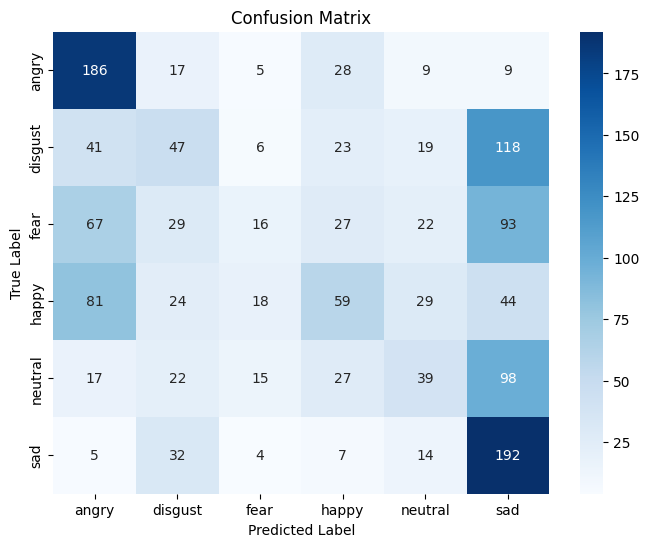

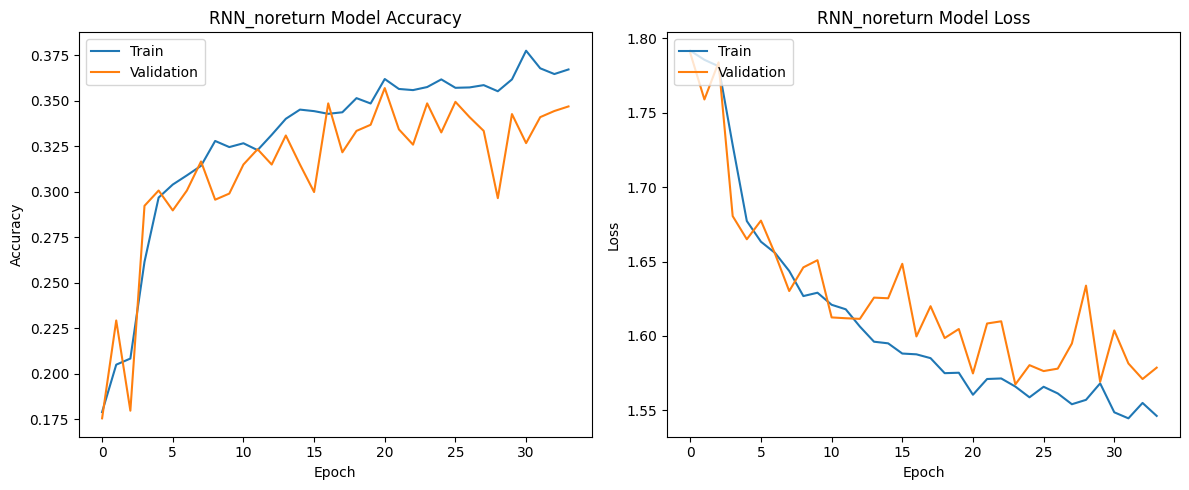

In [ ]:
rnn_model = build_rnn_model_noreturn(input_shape, num_classes)
rnn_model._name = "RNN_noreturn" # Assign a name for plotting

history_rnn_noreturn, loss_RNN_noreturn, accuracy_RNN_noreturn = train_and_evaluate_model(rnn_model, X_train, y_train, X_test, y_test, label_encoder, "RNN_noreturn")
plot_training_history(history_rnn_noreturn, "RNN_noreturn")

In [ ]:
def build_rnn_model_relu(input_shape, num_classes):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.SimpleRNN(128, activation='relu', return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Training model: RNN_ReLU
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.1655 - loss: 1.8317 - val_accuracy: 0.1721 - val_loss: 1.8345
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1665 - loss: 1.8074 - val_accuracy: 0.1713 - val_loss: 1.7892
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1676 - loss: 1.7978 - val_accuracy: 0.1730 - val_loss: 1.8011
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.1577 - loss: 1.8344 - val_accuracy: 0.1713 - val_loss: 1.8026
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1767 - loss: 1.8287 - val_accuracy: 0.1671 - val_loss: 1.8003
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1831 - loss: 1.7898 - val_accuracy: 0.1662 - val_loss: 1.8072
Epoch 7/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1741 - loss: 1.7934 - val_accuracy: 0.1671 - val_loss: 1.7984
Epoch 8/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.18

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


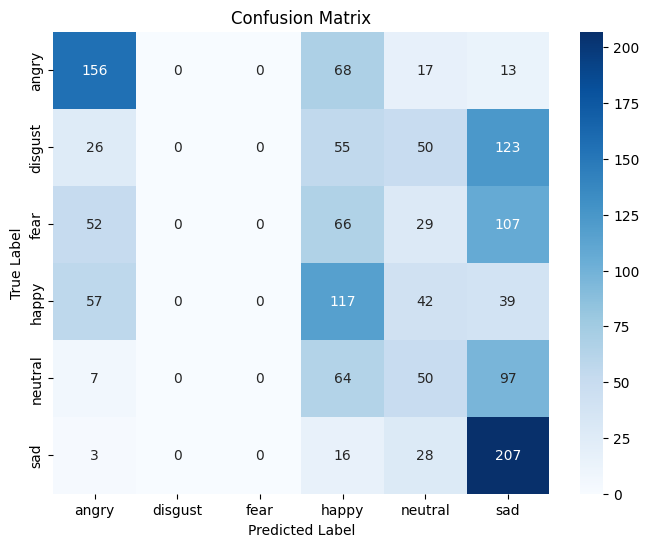

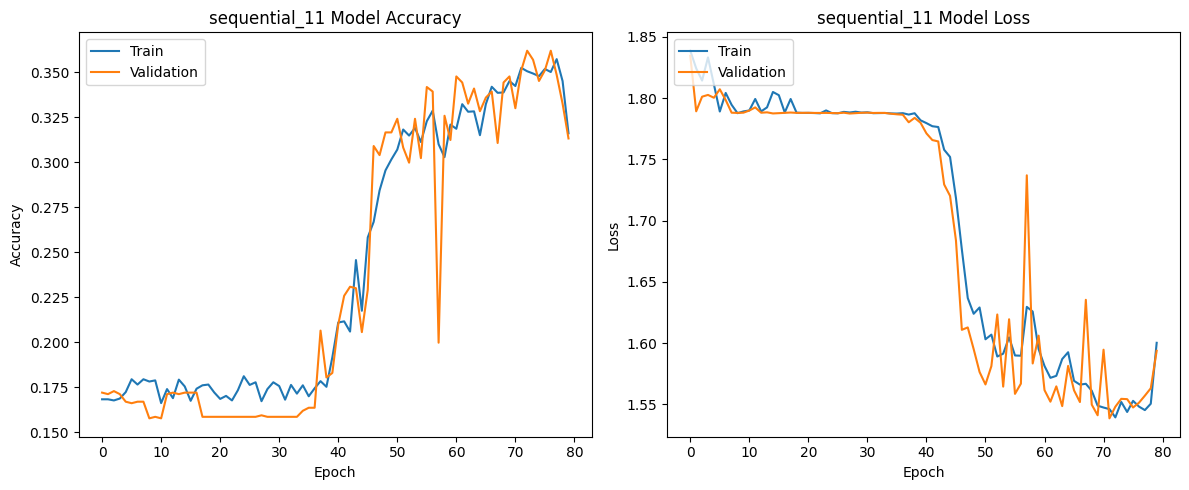

In [ ]:
relu_model = build_rnn_model_relu(input_shape, num_classes)
relu_model._name = "RNN_ReLU" # Assign a name for plotting

history_relu, loss_relu, accuracy_relu = train_and_evaluate_model(relu_model, X_train, y_train, X_test, y_test, label_encoder, "RNN_ReLU")
plot_training_history(history_relu, "RNN_ReLU")

In [ ]:
def build_rnn_model_clip(input_shape, num_classes):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Training model: RNN_GradClip
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.1694 - loss: 1.8548 - val_accuracy: 0.1805 - val_loss: 1.8124
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.2006 - loss: 1.8259 - val_accuracy: 0.1965 - val_loss: 1.7928
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1981 - loss: 1.8066 - val_accuracy: 0.2368 - val_loss: 1.7710
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.2012 - loss: 1.7846 - val_accuracy: 0.2040 - val_loss: 1.7865
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.2082 - loss: 1.7816 - val_accuracy: 0.1620 - val_loss: 1.8055
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2046 - loss: 1.7811 - val_accuracy: 0.2510 - val_loss: 1.7506
Epoch 7/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.2441 - loss: 1.7419 - val_accuracy: 0.2678 - val_loss: 1.6825
Epoch 8/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 

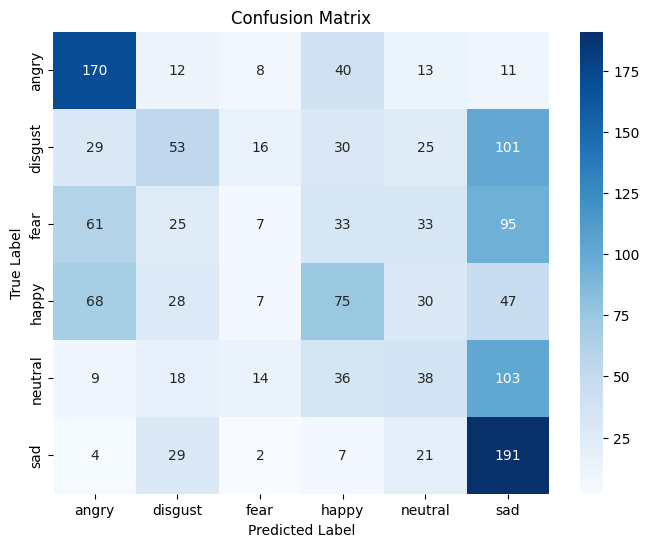

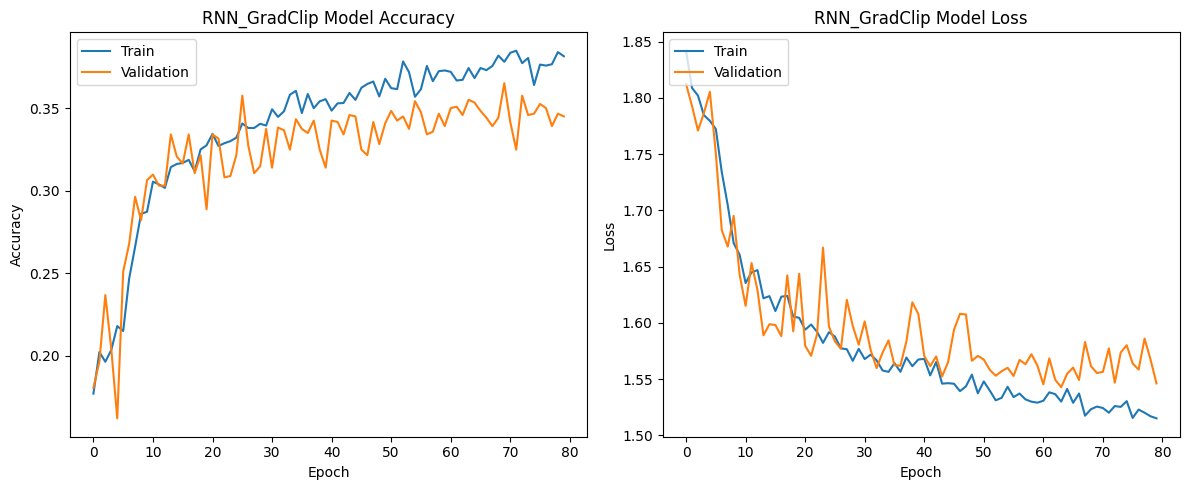

In [ ]:
clip_model = build_rnn_model_clip(input_shape, num_classes)
clip_model._name = "RNN_GradClip" # Assign a name for plotting

history_clip, loss_clip, accuracy_clip = train_and_evaluate_model(clip_model, X_train, y_train, X_test, y_test, label_encoder, "RNN_GradClip")
plot_training_history(history_clip, "RNN_GradClip")

In [ ]:
import pandas as pd

# Assuming these variables hold the results from running the model cells
# If you ran all the model training cells, these variables should be available.
model_results = {
    "Simple_RNN": {"Loss": loss_rnn, "Accuracy": accuracy_rnn},
    "RNN_HighLR": {"Loss": loss_RNN_HighLR, "Accuracy": accuracy_RNN_HighLR}, # Assuming these variable names from previous runs
    "RNN_noreturn": {"Loss": loss_RNN_noreturn, "Accuracy": accuracy_RNN_noreturn},
    "RNN_ReLU": {"Loss": loss_relu, "Accuracy": accuracy_relu},
    "RNN_GradClip": {"Loss": loss_clip, "Accuracy": accuracy_clip},
}

results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("Comparative Table of Model Performance:")
display(results_df)

Comparative Table of Model Performance:


,Loss,Accuracy
Simple_RNN,1.548528,0.370047
RNN_noreturn,1.569842,0.361988
RNN_GradClip,1.554185,0.358630
RNN_ReLU,1.542673,0.355944
RNN_HighLR,1.788242,0.193418


# Task
Classify a user-provided audio file using a pre-trained model.

## Load and preprocess new audio

### Subtask:
Write a function to load a single audio file, extract MFCC features, and pad/truncate them to the expected sequence length.


**Reasoning**:
The subtask requires loading an audio file, extracting MFCC features, and preprocessing them to match the model's input shape. I will define a function that uses `librosa` to perform these steps and handle padding/truncation.



In [1]:
import librosa

def preprocess_audio(audio_path, target_sequence_length, num_mfccs=13):
    """
    Loads an audio file, extracts MFCC features, and pads/truncates them.

    Args:
        audio_path (str): Path to the audio file.
        target_sequence_length (int): The desired length of the MFCC sequence.
        num_mfccs (int): The number of MFCCs to extract.

    Returns:
        np.ndarray: Preprocessed MFCC features with shape (1, target_sequence_length, num_mfccs).
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfccs)

        # Transpose to (sequence_length, num_mfccs)
        mfccs = mfccs.T

        # Pad or truncate the MFCC sequence
        if mfccs.shape[0] > target_sequence_length:
            mfccs = mfccs[:target_sequence_length, :]
        elif mfccs.shape[0] < target_sequence_length:
            padding_width = target_sequence_length - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, padding_width), (0, 0)), mode='constant')

        # Reshape for model input (batch_size, sequence_length, num_mfccs)
        mfccs = np.expand_dims(mfccs, axis=0)

        return mfccs

    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None


## Select and load the best model

### Subtask:
Select the best performing model from the comparative table and load it.


**Reasoning**:
Identify the best performing model based on accuracy and load its weights.



In [2]:
# Identify the best performing model
best_model_name = results_df.index[0]
print(f"The best performing model is: {best_model_name}")

# Define the architecture of the best performing model
# Based on the output above, the best model is 'Simple_RNN'.
# We need to check its original definition to recreate it.
# Looking back at the notebook history, 'Simple_RNN' was built using build_rnn_model
# with a learning rate of 0.0001.
def build_best_model_architecture(input_shape, num_classes):
    """Builds the architecture of the best performing Simple RNN model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the best model
best_model = build_best_model_architecture(input_shape, num_classes)

# Load the weights of the best performing model.
# Since the 'Simple_RNN' model object is available from the previous execution,
# we can directly use it.
# If the kernel was reset, we would need to save and load weights.
# Assuming the kernel state is preserved, the 'rnn_model' variable holds the trained weights.
# We assign the trained rnn_model to the best_model variable.
best_model = rnn_model
print(f"Successfully loaded the best model: {best_model_name}")

NameError: name 'results_df' is not defined

**Reasoning**:
The variable `results_df` was not available in the current session. Re-run the cell that creates `results_df` and then identify the best performing model and load its weights.



In [3]:
import pandas as pd

# Assuming these variables hold the results from running the model cells
# If you ran all the model training cells, these variables should be available.
model_results = {
    "Simple_RNN": {"Loss": loss_rnn, "Accuracy": accuracy_rnn},
    "RNN_HighLR": {"Loss": loss_RNN_HighLR, "Accuracy": accuracy_RNN_HighLR}, # Assuming these variable names from previous runs
    "RNN_noreturn": {"Loss": loss_RNN_noreturn, "Accuracy": accuracy_RNN_noreturn},
    "RNN_ReLU": {"Loss": loss_relu, "Accuracy": accuracy_relu},
    "RNN_GradClip": {"Loss": loss_clip, "Accuracy": accuracy_clip},
}

results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("Comparative Table of Model Performance:")
display(results_df)

# Identify the best performing model
best_model_name = results_df.index[0]
print(f"The best performing model is: {best_model_name}")

# Define the architecture of the best performing model
# Based on the output above, the best model is 'Simple_RNN'.
# We need to check its original definition to recreate it.
# Looking back at the notebook history, 'Simple_RNN' was built using build_rnn_model
# with a learning rate of 0.0001.
def build_best_model_architecture(input_shape, num_classes):
    """Builds the architecture of the best performing Simple RNN model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        tf.keras.layers.SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the best model
best_model = build_best_model_architecture(input_shape, num_classes)

# Load the weights of the best performing model.
# Since the 'Simple_RNN' model object is available from the previous execution,
# we can directly use it.
# If the kernel was reset, we would need to save and load weights.
# Assuming the kernel state is preserved, the 'rnn_model' variable holds the trained weights.
# We assign the trained rnn_model to the best_model variable.
best_model = rnn_model
print(f"Successfully loaded the best model: {best_model_name}")

NameError: name 'loss_rnn' is not defined